## Distribuição Territorial de Postos de Trabalho

**AUTORIA:** [REDE MOB](https://www.redemob.com.br/), com proximento metodológico inspirado e derivado do projeto [Acesso a Oportunidades](https://github.com/ipeaGIT/acesso_oport).

Este script faz a leitura e consolidação de dados de estabelecimentos de varejo ou serviços e dos respectivos postos de trabalho. A maior parte dos dados deriva da Relação Anual de Informações Sociais (RAIS), com complementos derivados do Cadastro Nacional dos Estabelecimentos de Saúde (CNES) e do Censo Escolar, para prover, respectivamente, informaçõs a respeito de serviços de saúde e de escolas sob a égide do setor público

**PANORAMA:**
- Faz a leitura dos dados — RAIS, CNES e Censo Escolar — com a API da Base dos Dados
- Quando os dados acima não possuem informações geográficas — latitude e longitude —, faz a geolocalização dos endereços a partir:
    - Da biblioteca [geobr](https://github.com/ipeaGIT/geobr); e
    - Do Cadastro Nacional de Endereços para Fins Estatísticos ([CNEFE](https://basedosdados.org/dataset/33b49786-fb5f-496f-bb7c-9811c985af8e?table=566ed7f2-db5f-4ac3-bfce-b579137c993c).
- Diferencia os posto de trabalho com o setor de atividade economica, tomando como base o [CONCLA](https://cnae.ibge.gov.br/?view=estrutura)
- Produz mapas e gráficos descritivos.


**MAIS INFORMAÇÕES:**
- [Layout da Plataforma]
- [Sumário dos Dados Disponíveis]
- *Lorem ipsum: Conteúdo do MOB de interesse, técnico ou de divulgação*

**LINKS DE INTERESSE:**
- links para materiais técnicos e acadêmicos gerais, externos, de referência a respeito do conteúdo abordado


# Instruções

Este script requer:
1. O [código do IBGE](https://www.ibge.gov.br/explica/codigos-dos-municipios.php) para o município
    - Caso se deseje fazer a análise de municípios vizinhos, fornecer uma lista com os códigos do IBGE destes municípios
  
2. [Chave referente a um projeto no Google Cloud](https://basedosdados.org/docs/access_data_bq)

# Parâmetros Definidos Pelo Usuário

In [265]:
# Backend preliminar
from getpass import getpass

In [266]:
# Forneça código do IBGE da cidade, ou lista de códigos
# se quiser cidades vizinhas. P. ex.:
# ibge_id = 3303302 -> Niterói
ibge_id = [3303302, 3304904, 3301900] # Niterói, São Gonçalo, Itaboraí

# Chave de API do Google Cloud Platform
gcloud_id = getpass("Chave de API do Google Cloud Platform: ")
    

# Backend

## Set Up Inicial

In [267]:
import pathlib
from string import ascii_uppercase

import basedosdados as bd
import geobr
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tobler.util import h3fy
from tqdm.auto import tqdm
import contextily as ctx
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib_map_utils.core.north_arrow import north_arrow

In [268]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('Solarize_Light2')

In [269]:
pd.options.display.float_format = '{:,.2f}'.format

# As Malhas Territorias

## Área de Estudo

In [270]:
def get_study_area(ibge_id):
    if not isinstance(ibge_id, list):
        ibge_id = [ibge_id]

    return pd.concat([
        geobr.read_census_tract(id_)
        for id_
        in ibge_id
        ]).astype({'code_muni': int})


tracts = get_study_area(ibge_id)

In [271]:
crs = tracts.estimate_utm_crs(datum_name='SIRGAS 2000')
crs

<Projected CRS: EPSG:31983>
Name: SIRGAS 2000 / UTM zone 23S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Brazil - between 48°W and 42°W, northern and southern hemispheres, onshore and offshore.
- bounds: (-48.0, -33.5, -42.0, 5.13)
Coordinate Operation:
- name: UTM zone 23S
- method: Transverse Mercator
Datum: Sistema de Referencia Geocentrico para las AmericaS 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [272]:
tracts = tracts.to_crs(crs)

Abaixo, utiliza-se a função h3fy, cuja documentação pode ser encontrada [aqui](https://pysal.org/tobler/generated/tobler.util.h3fy.html). A ideia é encontrar a malha hexagonal referente à área de estudo — os municípios cujo código está na variável `ibge_id`, acima.

In [273]:
hexes = h3fy(tracts, resolution=9)

# Relação Anual de Informações Sociais (RAIS)

Importação dos dados de empregos formais a partir da base de dados da RAIS.

## Leitura da Base dos Dados

In [274]:
def _sql_style_list(sequence):
    single_quoted_elements = [f"'{c}'" for c in sequence]
    return ', '.join(single_quoted_elements)

In [275]:
# Prepara a consulta para requisição na Base dos Dados

job_vars = [
    'ano',
    'id_municipio',
    'cep',
    'tipo_estabelecimento',
    'indicador_atividade_ano',
    'quantidade_vinculos_ativos',
    'natureza_juridica',
    'cnae_2',
    ]

# TO DO: possibilitar lidar com séries históricas
query = (
    f"SELECT {', '.join(job_vars)} " 
    "FROM basedosdados.br_me_rais.microdados_estabelecimentos "
    f"WHERE id_municipio IN ({_sql_style_list(tracts.code_muni.unique())}) "
    "AND ano IN (2023);"
    )

In [276]:
rais = bd.read_sql(
    query,
    billing_project_id=gcloud_id,
    )

Downloading: 100%|██████████|


## Limpeza

Conforme mencionado no Guia, dados da RAIS precisam passar por um tratameto para corrigir algumas inconsistências. Para isso, será seguido (com adaptações) o procedimento documentado na linguagem R em https://bit.ly/git_access_op_rais_pre_processing.

    ⁕ NADALIN, V. G. Localização de empregos formais e transporte público de massa. Brasília: Ipea, 2018. (Nota Técnica, n. 13). Disponível em <https://bit.ly/2YX6K5O>

In [277]:
def flag_public_sector(rais):
    civil_service_jobs = (
        rais.natureza_juridica.str.startswith('1')
        )
    
    state_owned_firms = (rais.natureza_juridica == '2011')
    
    mask = (
        civil_service_jobs | state_owned_firms
        )
    
    return rais.assign(
                    sector=lambda x: np.where(
                                            mask,
                                            'Publico',
                                            'Privado',
                                            )
                    )


rais = flag_public_sector(rais)

In [278]:
def remove_public_sector(rais):    
    return rais.loc[rais.sector == 'Privado'].drop(columns='sector')


rais = remove_public_sector(rais)

In [279]:
def clean_job_outliers(rais):
    return (
        rais
        .groupby(['ano', 'cnae_2'], as_index=False)
        .apply(_clean_sector)
        .reset_index(drop=True)
        .astype({'quantidade_vinculos_ativos': float})
        .round({'quantidade_vinculos_ativos': 0})
        .astype({'quantidade_vinculos_ativos': int})
    )


def _clean_sector(group):
    problematic_sectors = [
        '35', # ELETRICIDADE, GÁS E OUTRAS UTILIDADES
        '36', # CAPTAÇÃO, TRATAMENTO E DISTRIBUIÇÃO DE ÁGUA
        '38', # COLETA, TRATAMENTO E DISPOSIÇÃO DE RESÍDUOS; RECUPERAÇÃO DE MATERIAIS
        '41', # CONSTRUÇÃO DE EDIFÍCIOS
        '42', # OBRAS DE INFRA-ESTRUTURA
        '43', # SERVIÇOS ESPECIALIZADOS PARA CONSTRUÇÃO
        '49', # TRANSPORTE TERRESTRE
        '51', # TRANSPORTE AÉREO
        '562', # Catering, bufê e outros serviços de comida preparada
        '64', # ATIVIDADES DE SERVIÇOS FINANCEIROS
        '78', # SELEÇÃO, AGENCIAMENTO E LOCAÇÃO DE MÃO-DE-OBRA
        '80', # ATIVIDADES DE VIGILÂNCIA, SEGURANÇA E INVESTIGAÇÃO
        '81', # SERVIÇOS PARA EDIFÍCIOS E ATIVIDADES PAISAGÍSTICAS
        '82', # SERVIÇOS DE ESCRITÓRIO, DE APOIO ADMINISTRATIVO E OUTROS SERVIÇOS PRESTADOS A EMPRESAS
        '84', # ADMINISTRAÇÃO PÚBLICA, DEFESA E SEGURIDADE SOCIAL
        ]
    sector_mask = group.cnae_2.str.startswith(tuple(problematic_sectors))
        
    ceiling = (
        group
        .loc[sector_mask, 'quantidade_vinculos_ativos']
        .pipe(
            lambda x: x[x > 0]
            )
        .quantile(.95)
        )
        
    job_mask = group.quantidade_vinculos_ativos > ceiling
    
    mask = sector_mask & job_mask
    
    group['quantidade_vinculos_ativos'] = np.where(
                                            mask,
                                            ceiling,
                                            group.quantidade_vinculos_ativos,
                                            )
    return group



rais = clean_job_outliers(rais)

## Setores da Economia

In [280]:
# Etiqueta os setores CNAE na RAIS

cnae_sections = [
    (0, 3),
    (5, 9),
    (10, 33),
    (35, 35.1), # Apenas um artificio para gerar um intervalo
    (36, 39),   # pois ha so uma subdivisao. Isso se repete abaixo
    (41, 43),   # algumas vezes
    (45, 47),
    (49, 53),
    (55, 56),
    (58, 63),
    (64, 66),
    (68, 68.1),
    (69, 75),
    (77, 82),
    (84, 84.1),
    (85, 85.1),
    (86, 88),
    (90, 93),
    (94, 96),
    (97, 97.1),
    (99, 99.1),
]

cnae_sections = pd.IntervalIndex.from_tuples(cnae_sections, closed='both')

binned_cnae = pd.cut(
    rais.cnae_2.str.extract(r'(\d\d)').astype(int).squeeze(),
    bins=cnae_sections,
)

labeled_cnae = binned_cnae.astype(str).replace({
    str(cat): letter
    for cat, letter
    in zip(
        cnae_sections,
        ascii_uppercase[:len(cnae_sections)]
    )
})

rais['grupo_cnae'] = labeled_cnae

## Geolocalização da RAIS

Os dados da RAIS não estão geolocalizados a priori: eles contêm informações a respeito do CEP de cada estabelecimento comercial, de maneira que uma correta localização no território exige associar o CEP à uma coordenada geográfica que o represente. Para isso, utiliza-se o [diretório de CEPs](https://basedosdados.org/dataset/33b49786-fb5f-496f-bb7c-9811c985af8e?table=566ed7f2-db5f-4ac3-bfce-b579137c993c) presente na Base dos Dados.

### Padronização dos CEPs

Registros com CEPs inválidos ou ausentes são removidos, a não ser que haja possibilidade de padronização.

A padronização é importante, sobretudo, porque em alguns casos, os CEPs começam com um zero à esquerda, o que pode fazer com que o dígito à esquerda seja perdido nas manipulações computacionais (isso é um problema sobretudo em São Paulo). Por segurança, para garantir que não haverá problemas (mesmo sendo esse um caso relativamente raro no país), força-se os CEPs a sempre terem 8 dígitos: quando há 7, acrescenta-se um zero à esquerda.

In [281]:
# Ajuste nos CEPs
rais = rais.loc[rais.cep.notnull()]
rais['cep'] = rais.cep.map('{:>08}'.format)

### Enderecos

In [282]:
# Requisição de CEPs na Base dos Dados
query = (
    "SELECT cep, centroide " 
    "FROM basedosdados.br_bd_diretorios_brasil.cep "
    f"WHERE id_municipio IN ({_sql_style_list(tracts.code_muni.unique())}) "
    )

In [283]:
ceps = bd.read_sql(
    query,
    billing_project_id=gcloud_id,
    )

ceps['cep'] = ceps.cep.map(lambda x: x.get('cep'))
ceps = gpd.GeoDataFrame(
    ceps,
    crs=4674,
    geometry=gpd.GeoSeries.from_wkt(ceps.centroide)
    ).to_crs(crs).drop(columns='centroide')

Downloading: 100%|██████████|


In [284]:
rais = ceps.merge(rais)

## Complementos

Houve remoção dos setores públicos, conforme explicado acima, o que acaba por remover parte dos postos de trabalho e os estabelecimentos referentes à saúde e à educação. Parte destes será então agora acrescentados a partir das bases de dados do CNES e do Censo Escolar.

### Educação

In [285]:
# Consulta de escolas na Base dos Dados

school_vars = [
    'id_escola',
    'dependencia_administrativa',
    'etapas_modalidades_oferecidas',
    'latitude',
    'longitude',
    ]

query = (
    f"SELECT {', '.join(school_vars)} " 
    "FROM basedosdados.br_bd_diretorios_brasil.escola "
    f"WHERE id_municipio IN ({_sql_style_list(ibge_id)}) "
    )

schools = bd.read_sql(
    query,
    billing_project_id=gcloud_id,
    )

Downloading: 100%|██████████|


In [286]:
# Consulta de trabalhadores e alunos na Base dos Dados

query = (
    f"SELECT * " 
    "FROM basedosdados.br_inep_censo_escolar.escola "
    f"WHERE id_municipio IN ({_sql_style_list(ibge_id)}) "
    "AND ano = 2023"
    )

school_census = bd.read_sql(
    query,
    billing_project_id=gcloud_id,
    )

Downloading: 100%|██████████|


In [287]:
def filter_school_census(census):
    """
    Filters the school census data for regular, public, and active schools.
    Returns a DataFrame with enrollments, teachers, and other workers.
    """
    # Filter for regular, active schools
    filtered = census.loc[
        (census.regular == 1) &  # Offers teaching in consecutive stages
        (census.tipo_situacao_funcionamento == '1')  # Active schools
    ]

    # Classify schools as 'Public' or 'Private'
    filtered['rede'] = np.where(
        filtered.rede.isin(['1', '2', '3']),
        'Publica',
        'Privada',
    )

    # Select variables of interest
    vars_of_interest = [
        'id_escola',
        'rede',
        'quantidade_matricula_infantil',
        'quantidade_matricula_fundamental',
        'quantidade_matricula_medio',
    ]
    enrollments = filtered.reindex(columns=vars_of_interest)

    # Extract teacher counts
    teachers = filtered['quantidade_docente_educacao_basica']
    teachers = teachers.rename('quantidade_docente')

    # Sum other worker counts
    other_workers = (
        filtered
        .filter(like='quantidade_profissional')
        .sum(axis=1)
        .rename('quantidade_profissional')
    )

    # Combine results into a single DataFrame
    return pd.concat([enrollments, teachers, other_workers], axis='columns')


school_census = filter_school_census(school_census)

In [288]:
# Consolidação das escolas

# Limpando anomalias de latitude e longitude
schools = (
    schools
    .loc[
        schools['latitude'].notnull() & schools['longitude'].notnull()
    ]
    .assign(
        latitude=lambda df: pd.to_numeric(df['latitude'], errors='coerce'),
        longitude=lambda df: pd.to_numeric(df['longitude'], errors='coerce')
    )
    .dropna(subset=['latitude', 'longitude'])
)


# Convertendo para GeoDataFrame e unindo com o censo escolar
schools = (
    gpd.GeoDataFrame(
        schools,
        crs=4674,
        geometry=gpd.points_from_xy(schools['longitude'], schools['latitude'])
    )
    .to_crs(crs)
    .drop(columns=['longitude', 'latitude'])
    .merge(school_census, on='id_escola', how='left')
    .dropna(subset=['quantidade_docente'])
)

In [289]:
def schools_to_rais(ceps, schools):
    """
    Merges the RAIS and school census data based on the nearest school.
    Returns a DataFrame with the merged data.
    """
    # Perform a spatial join to find the nearest school for each RAIS record
    merged = gpd.sjoin_nearest(
        schools,
        ceps,
        how='inner',
        max_distance=1000,
    )

    # Drop unnecessary columns
    merged = (
        merged
        .loc[merged.rede == 'Publica']
        .drop(columns=['index_right'])
        .assign(
            quantidade_vinculos_ativos=lambda x: x['quantidade_docente'] + x['quantidade_profissional'],
            grupo_cnae='P',
            )
        .reindex(columns=['cep', 'quantidade_vinculos_ativos', 'grupo_cnae', 'geometry'])
        .dissolve(
            by=['cep', 'grupo_cnae'],
            aggfunc={'quantidade_vinculos_ativos': 'sum'},
            )
        .assign(
            geometry=lambda x: x.geometry.centroid,
            )
        .reset_index()
        )

    return merged


schools = schools_to_rais(ceps, schools)

### Saúde

In [290]:
query = (
    f"SELECT * " 
    "FROM basedosdados.br_ms_cnes.estabelecimento "
    f"WHERE id_municipio IN ({_sql_style_list(ibge_id)}) "
    "AND ano = 2023 "
    "AND mes = 9"
    )

cnes = bd.read_sql(
    query,
    billing_project_id=gcloud_id,
    )

Downloading: 100%|██████████|


In [291]:
def summarize_cnes(cnes):
    return (
        cnes
        .pipe(_get_complexity)
        .pipe(_count_beds)
        .pipe(
            lambda x: x.loc[
                (x.tipo_pessoa == '3') # Juridical persons
                & (x.complexidade.notnull()) # Hospital or ambulatory care
                & (x.indicador_vinculo_sus == '1') # SUS-linked
            ]
        )
        .reindex(
            columns=[
                'id_estabelecimento_cnes',
                'cep',
                'complexidade',
                'indicador_vinculo_sus',
                'quantidade_leitos',
                'quantidade_consultorios',
                'indicador_atencao_hospitalar',
            ]
        )
        .set_index(
            'id_estabelecimento_cnes'
        )
    )


def _highest_complexity(row):
    s = row[row == 1]
    for c in ['alta', 'media', 'basica']:
        if s.index.str.contains(c, regex=False).any():
            return c
    
    return None


def _get_complexity(cnes):
    df = cnes.filter(like='indicador_gestao')
    return cnes.assign(
        complexidade=df.apply(_highest_complexity, axis='columns')
    )


def _count_beds(cnes):
    return cnes.assign(
        quantidade_leitos=cnes.filter(like='quantidade_leit').sum(1),
        quantidade_consultorios=cnes.filter(like='quantidade_consul').sum(1),
    )

cnes = summarize_cnes(cnes)

In [292]:
query = (
    f"SELECT * "
    "FROM basedosdados.br_ms_cnes.profissional "
    f"WHERE id_municipio IN ({_sql_style_list(ibge_id)}) "
    "AND ano = 2023 "
    "AND mes = 9"
    )

docs = bd.read_sql(
    query,
    billing_project_id=gcloud_id,
    )

docs = (
    docs
    .groupby(['id_estabelecimento_cnes'])
    .size()
    .sort_values()
    .to_frame('quantidade_trabalhadores_saude')   
)

Downloading: 100%|██████████|


In [293]:
cnes = (
    cnes
    .merge(
        docs,
        left_index=True,
        right_index=True,
    )
)

In [294]:
cnes = ceps.merge(
    cnes,
    on='cep',
    how='inner',
)

In [295]:
cnes = (
    cnes
    .dissolve('cep', aggfunc={'quantidade_trabalhadores_saude': 'sum'})
    .assign(
        grupo_cnae='Q',
        )
    .rename(columns={'quantidade_trabalhadores_saude': 'quantidade_vinculos_ativos'})
    .reset_index()
    )

### Consolidação

In [296]:
all_jobs = pd.concat([
    rais.loc[rais.indicador_atividade_ano == 1],
    schools,
    cnes,
    ],
    ignore_index=True
)

In [297]:
all_jobs.id_municipio.unique()

array(['3303302', '3301900', '3304904', nan], dtype=object)

# Visualizações

A seguir são demonstrados graficamente os totais de empregos por grupo do CNAE.

In [298]:
setores_cnae = {
    "A": "Agricultura e Pesca",
    "B": "Indústrias Extrativas",
    "C": "Indústrias de Transformação",
    "D": "Eletricidade e Gás",
    "E": "Água e Gestão de Resíduos",
    "F": "Construção",
    "G": "Comércio e Reparação de Veículos",
    "H": "Transporte e Armazenagem",
    "I": "Alojamento e Alimentação",
    "J": "Informação e Comunicação",
    "K": "Finanças e Seguros",
    "L": "Atividades Imobiliárias",
    "M": "Serviços Profissionais e Técnicos",
    "N": "Serviços Administrativos",
    "O": "Administração Pública",
    "P": "Educação",
    "Q": "Saúde e Assistência Social",
    "R": "Artes e Recreação",
    "S": "Outros Serviços",
    "T": "Serviços Domésticos",
    "U": "Organizações Internacionais",
}

ibge_names = {
    '3303302': "Niterói",
    '3304904': "São Gonçalo",
    '3301900': "Itaboraí"
}

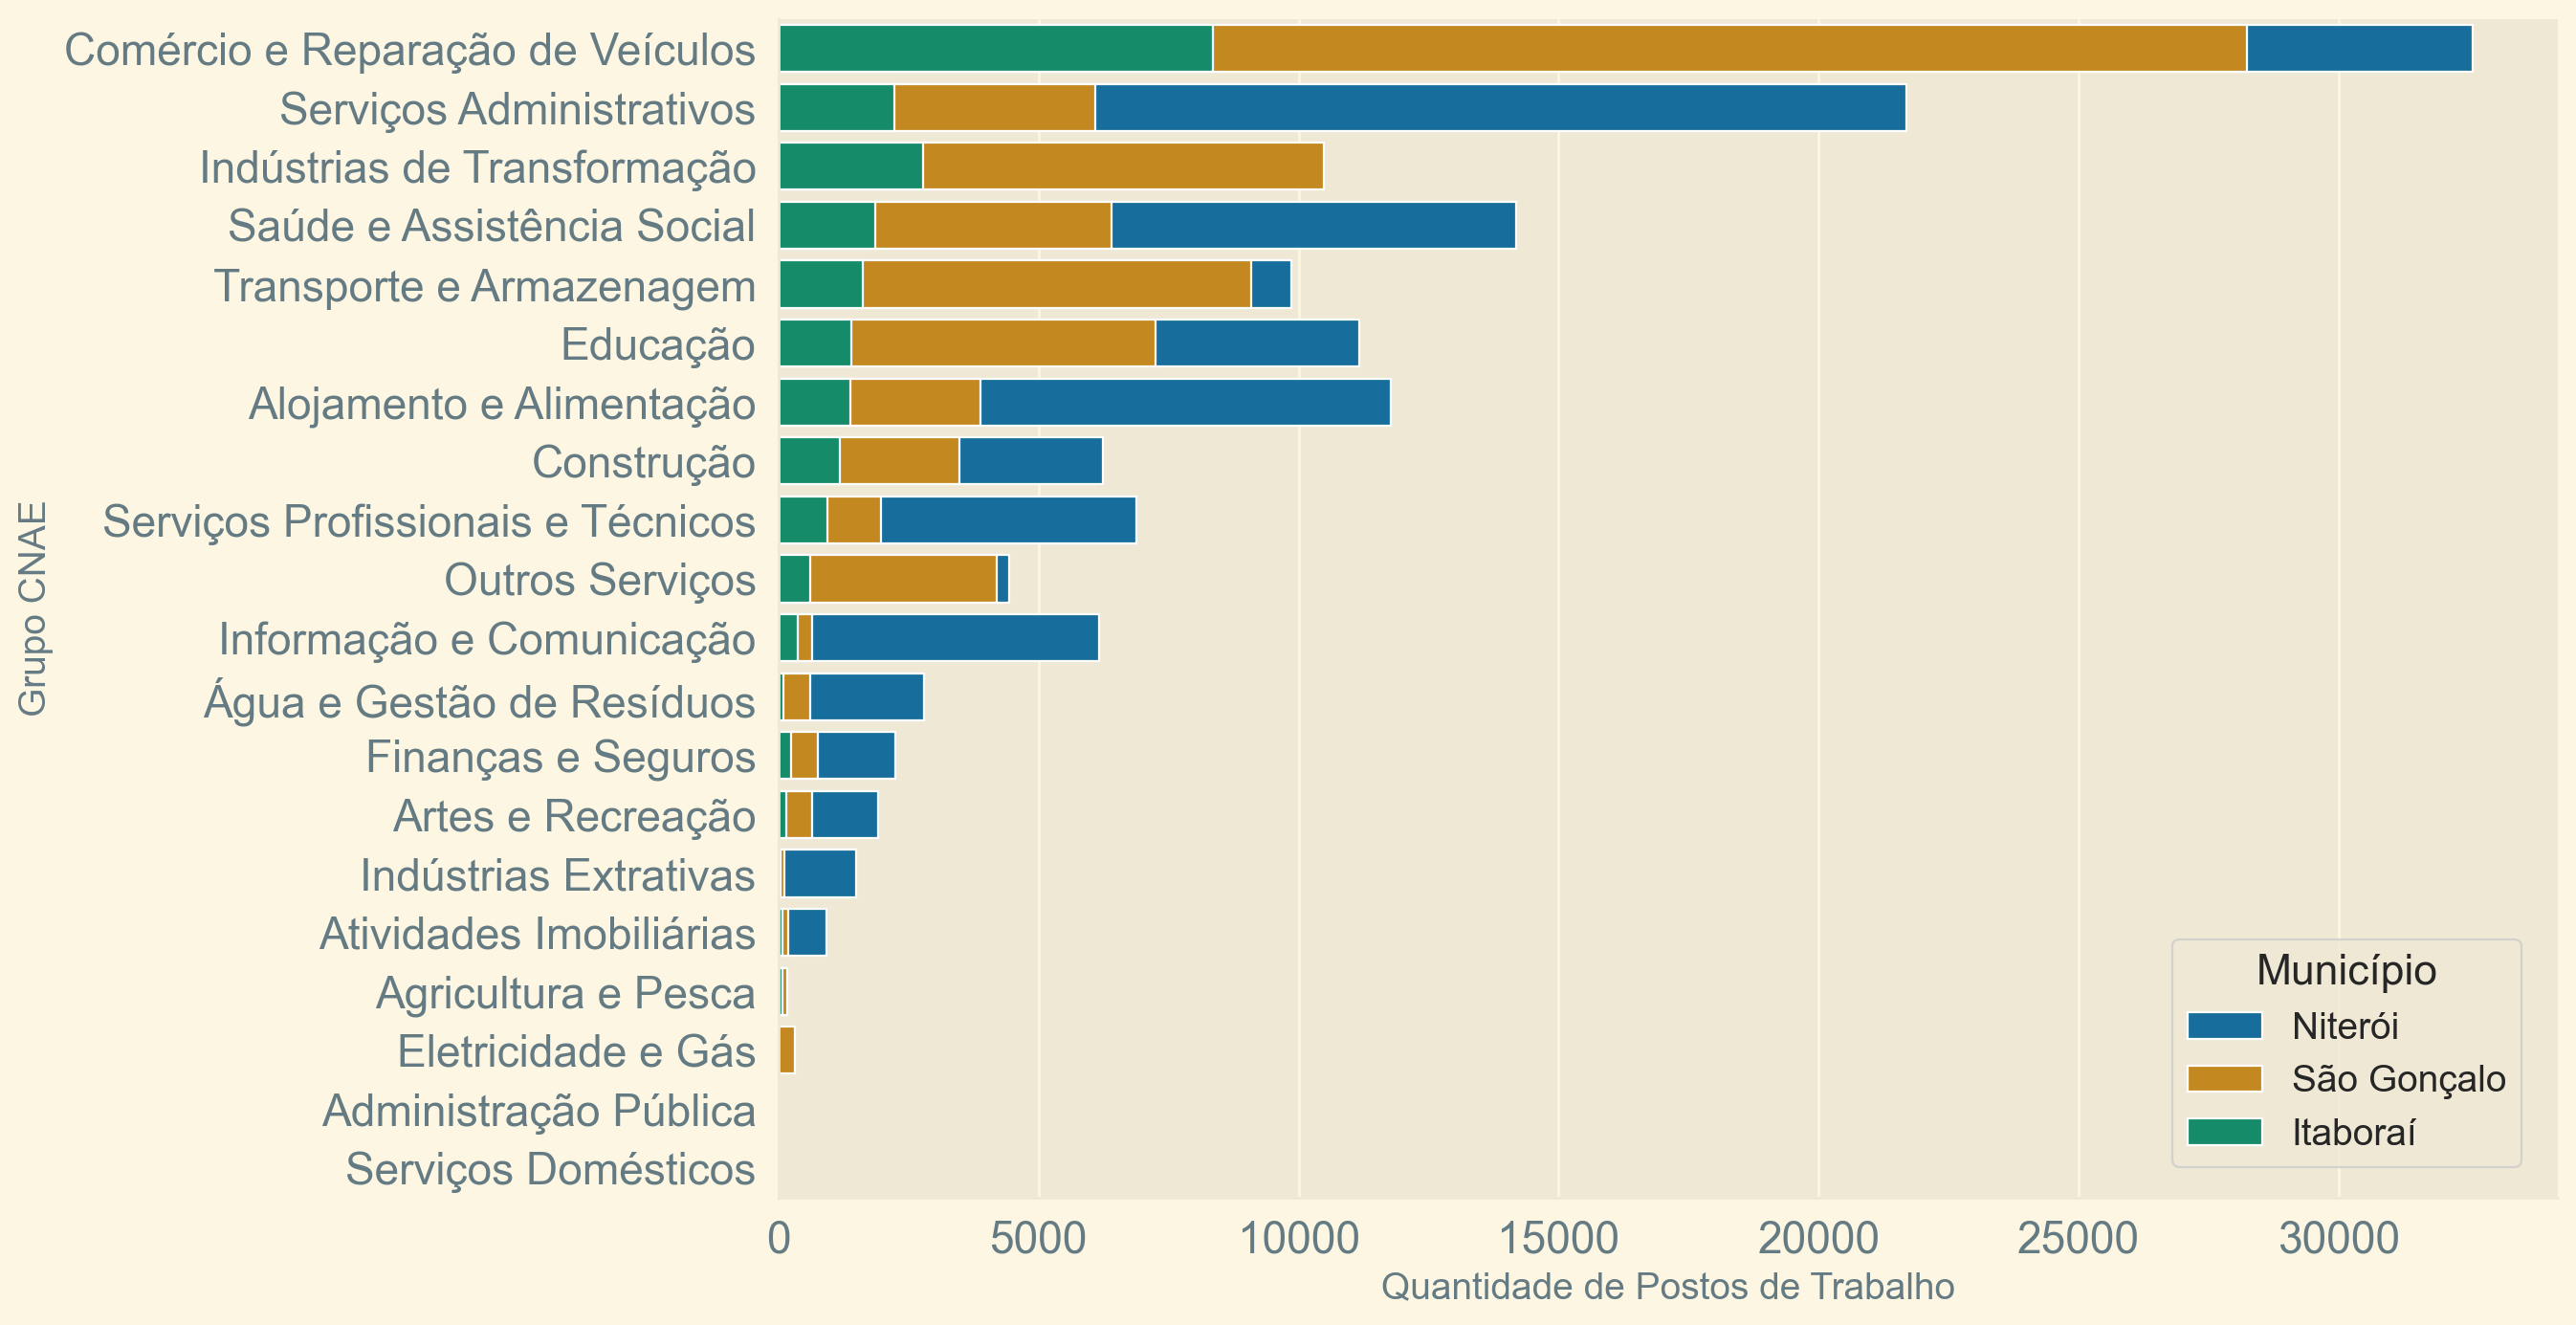

In [299]:
# Group data by CNAE group, year, AND city
grouped_data_by_city = (
    all_jobs
    .dropna(subset=['cep'])
    .replace({'id_municipio': ibge_names})
    .groupby(['grupo_cnae', 'id_municipio', 'ano'], as_index=False)
    .agg({'quantidade_vinculos_ativos': 'sum'})
    .rename(columns={'quantidade_vinculos_ativos': 'Quantidade de Postos de Trabalho'})
    .astype({'ano': 'str'})
    .replace({'grupo_cnae': setores_cnae}) # Assuming setores_cnae is your mapping
)

# Calculate total jobs per CNAE group for sorting
total_jobs_per_cnae = (
    grouped_data_by_city
    .groupby('grupo_cnae', as_index=False)['Quantidade de Postos de Trabalho']
    .sum()
    .sort_values(by='Quantidade de Postos de Trabalho', ascending=False)
)
cnae_order = total_jobs_per_cnae['grupo_cnae'].tolist()

import seaborn as sns
import matplotlib.pyplot as plt
import pathlib # Keep pathlib if you're using it

# Assuming 'grouped_data_by_city' and 'cnae_order' are prepared as above
# and 'setores_cnae' is a dictionary for renaming

#sns.set_style("whitegrid")
#sns.set_context("paper")

plt.figure(figsize=(12, 8)) # Adjust figure size as needed

ax = sns.barplot(
    data=grouped_data_by_city.sort_values('Quantidade de Postos de Trabalho', ascending=False),
    y='grupo_cnae',
    x='Quantidade de Postos de Trabalho',
    hue='id_municipio',     # This will create segments for each city
    order=cnae_order,       # Use the pre-calculated order
    #hue_order=ibge_names.values(), # Order the legend by city names
    dodge=False,            # Ensure bars are stacked
    palette='colorblind'     # Example: Choose a palette for cities
)

ax.set_xlabel("Quantidade de Postos de Trabalho", fontsize=14)
ax.set_ylabel("Grupo CNAE", fontsize=14)
ax.tick_params(labelsize='xx-large')
ax.legend(
    title='Município',
    title_fontsize=16,
    fontsize=14,
    bbox_to_anchor=(0.99, 0.01),
    loc='lower right',
    )

sns.despine()

outpath = pathlib.Path("../outputs/mapas/rais_2023_stacked.png") # New name
plt.savefig(outpath, dpi=600, bbox_inches="tight")

plt.show()

In [301]:
def gaussian_kernel_weights(
    distances: np.ndarray, bandwidth: float
) -> np.ndarray:
    """
    Calcula os pesos do kernel Gaussiano.

    Parâmetros
    ----------
    distances : np.ndarray
        Array de distâncias.
    bandwidth : float
        Largura de banda (sigma, σ) do kernel Gaussiano.

    Retorna
    -------
    np.ndarray
        Array de pesos Gaussianos.
    """
    return np.exp(-0.5 * (distances / bandwidth) ** 2)


def _get_smoothing_components_at_centroid(
    centroid_geometry: object,  # Geometria do centroide (shapely.geometry)
    nodes_df_projected: gpd.GeoDataFrame,
    nodes_spatial_index: object,  # Índice espacial (rtree.index.Index)
    metric_column_name: str,
    bandwidth: float,
    max_distance_cutoff: float,
) -> tuple[float, float]:
    """
    Calcula a soma ponderada da métrica e a soma dos pesos para um centroide.
    Função auxiliar interna.

    Retorna
    -------
    tuple[float, float]
        (soma_ponderada_metrica, soma_dos_pesos).
        (np.nan, np.nan) se não houver nós válidos.
    """
    # Busca inicial por nós próximos usando o índice espacial e a caixa
    # delimitadora (bounds) do buffer circular para otimizar.
    candidate_indices = list(
        nodes_spatial_index.intersection(
            centroid_geometry.buffer(max_distance_cutoff).bounds
        )
    )

    if not candidate_indices:
        return np.nan, np.nan

    nearby_nodes = nodes_df_projected.iloc[candidate_indices]
    actual_distances = nearby_nodes.geometry.distance(centroid_geometry).values
    distance_mask = actual_distances <= max_distance_cutoff # Filtro final

    if not np.any(distance_mask):
        return np.nan, np.nan

    final_distances = actual_distances[distance_mask]
    metric_values = nearby_nodes.loc[
        distance_mask, metric_column_name
    ].values

    kernel_w = gaussian_kernel_weights(final_distances, bandwidth)
    sum_kernel_w = np.sum(kernel_w)

    if sum_kernel_w == 0: # Pouco provável com kernel gaussiano se houver nós
        return np.nan, np.nan

    sum_weighted_metric = np.sum(kernel_w * metric_values)
    return sum_weighted_metric, sum_kernel_w


# --- Funções de Montagem de Métricas ---

def _assemble_average_metric(
    config: dict,
    intermediate_sums: dict,
    hex_grid: gpd.GeoDataFrame
) -> None:
    """
    Calcula e adiciona uma métrica suavizada do tipo 'average' ao hex_grid.
    """
    output_col_name = config["name"]
    metric_col = config["column"]
    
    sum_weighted_metric_arr = intermediate_sums[metric_col][
        "sum_weighted_metric"
    ]
    sum_weights_arr = intermediate_sums[metric_col]["sum_weights"]
    
    hex_grid[output_col_name] = np.where(
        (np.isnan(sum_weights_arr)) | (sum_weights_arr == 0),
        np.nan,
        sum_weighted_metric_arr / sum_weights_arr
    )

def _assemble_sum_metric(
    config: dict,
    intermediate_sums: dict,
    hex_grid: gpd.GeoDataFrame
) -> None:
    """
    Adiciona uma métrica suavizada do tipo 'sum' (soma ponderada) ao hex_grid.
    """
    output_col_name = config["name"]
    metric_col = config["column"]
    hex_grid[output_col_name] = intermediate_sums[metric_col][
        "sum_weighted_metric"
    ]

def _assemble_ratio_metric(
    config: dict,
    intermediate_sums: dict,
    hex_grid: gpd.GeoDataFrame
) -> None:
    """
    Calcula e adiciona uma métrica suavizada do tipo 'ratio' ao hex_grid.
    Opcionalmente, salva as somas suavizadas do numerador e denominador.
    """
    output_col_name = config["name"]
    num_col = config["numerator_column"]
    den_col = config["denominator_column"]

    sum_w_numerator_arr = intermediate_sums[num_col][
        "sum_weighted_metric"
    ]
    sum_w_denominator_arr = intermediate_sums[den_col][
        "sum_weighted_metric"
    ]

    num_smooth_sum_output_col = config.get("output_name_num_smooth")
    if num_smooth_sum_output_col:
        hex_grid[num_smooth_sum_output_col] = sum_w_numerator_arr
    
    den_smooth_sum_output_col = config.get("output_name_den_smooth")
    if den_smooth_sum_output_col:
        hex_grid[den_smooth_sum_output_col] = sum_w_denominator_arr

    hex_grid[output_col_name] = np.where(
        (np.isnan(sum_w_denominator_arr)) | \
        (sum_w_denominator_arr == 0) | \
        (np.isnan(sum_w_numerator_arr)),
        np.nan,
        sum_w_numerator_arr / sum_w_denominator_arr
    )


# --- Função Principal de Suavização ---

def compute_geographical_smoothing(
    nodes_df: gpd.GeoDataFrame,
    metrics_config: list[dict],
    study_area_df: gpd.GeoDataFrame,
    hex_grid_resolution: int,
    projected_crs_epsg: str | int = "EPSG:31983",
    kernel_bandwidth: float = 300.0,
    max_influence_distance: float = 1500.0,
) -> gpd.GeoDataFrame:
    """
    Suaviza métricas de nós (pontos) sobre uma grade hexagonal.

    Permite calcular médias locais ponderadas, somas locais ponderadas,
    ou razões de somas locais ponderadas, conforme `metrics_config`.

    Exemplo de `metrics_config`:
    [
        {'name': 'temp_media_suavizada', 'type': 'average',
         'column': 'temperatura_no_no'},
        {'name': 'pop_total_suavizada_soma', 'type': 'sum',
         'column': 'populacao_no_no'},
        {'name': 'renda_pc_suavizada_razao', 'type': 'ratio',
         'numerator_column': 'renda_total_no_no',
         'denominator_column': 'populacao_total_no_no'}
    ]

    Parâmetros
    ----------
    nodes_df : gpd.GeoDataFrame
        Dados pontuais com atributos a serem suavizados.
    metrics_config : list of dict
        Configuração das métricas a serem suavizadas.
    study_area_df : gpd.GeoDataFrame
        Área para geração da grade hexagonal.
    hex_grid_resolution : int
        Resolução H3 para a grade.
    projected_crs_epsg : str ou int, opcional
        EPSG do SRC projetado. Padrão "EPSG:31983".
    kernel_bandwidth : float, opcional
        Largura de banda (σ) do kernel Gaussiano. Padrão 300.0.
    max_influence_distance : float, opcional
        Distância máxima para influência dos nós. Padrão 1500.0.

    Retorna
    -------
    gpd.GeoDataFrame
        Grade hexagonal com colunas para cada métrica suavizada.
    """
    # --- Validações Iniciais ---
    if not isinstance(nodes_df, gpd.GeoDataFrame) or \
       not isinstance(study_area_df, gpd.GeoDataFrame):
        raise TypeError(
            "Parâmetros 'nodes_df' e 'study_area_df' devem ser GeoDataFrames."
        )
    for config_item in metrics_config: # Renomeado para evitar conflito
        if "name" not in config_item or "type" not in config_item:
            raise ValueError(
                "Cada config de métrica deve ter 'name' e 'type'."
            )
        cfg_type = config_item["type"] # Renomeado para evitar conflito
        if cfg_type in ["average", "sum"]:
            if "column" not in config_item or \
               config_item["column"] not in nodes_df.columns:
                raise ValueError(
                    f"Coluna '{config_item.get('column')}' para tipo "
                    f"'{cfg_type}' não encontrada ou não especificada."
                )
        elif cfg_type == "ratio":
            if "numerator_column" not in config_item or \
               "denominator_column" not in config_item or \
               config_item["numerator_column"] not in nodes_df.columns or \
               config_item["denominator_column"] not in nodes_df.columns:
                raise ValueError(
                    "Colunas de num/den para tipo 'ratio' "
                    "não encontradas ou não especificadas."
                )
        else:
            raise ValueError(f"Tipo de métrica desconhecido: {cfg_type}")
    if kernel_bandwidth <= 0:
        raise ValueError("'kernel_bandwidth' deve ser positivo.")
    if max_influence_distance <= 0:
        raise ValueError("'max_influence_distance' deve ser positivo.")

    # --- Preparação de Dados e Geometrias ---
    nodes_projected = nodes_df.to_crs(projected_crs_epsg)
    try:
        nodes_spatial_index = nodes_projected.sindex
    except Exception as e:
        raise RuntimeError(
            "Falha ao criar índice espacial. Verifique 'rtree'."
        ) from e

    study_area_geographic = study_area_df.to_crs("EPSG:4326")
    hex_grid_geographic = h3fy(
        study_area_geographic, resolution=hex_grid_resolution,
    )
    hex_grid = hex_grid_geographic.to_crs(projected_crs_epsg)
    centroids_projected = hex_grid.geometry.centroid

    # --- Cálculo dos Componentes de Suavização ---
    intermediate_sums = {}
    columns_to_process = set()
    for config_item in metrics_config:
        if config_item["type"] in ["average", "sum"]:
            columns_to_process.add(config_item["column"])
        elif config_item["type"] == "ratio":
            columns_to_process.add(config_item["numerator_column"])
            columns_to_process.add(config_item["denominator_column"])

    print(
        f"Calculando componentes para {len(columns_to_process)} colunas base "
        f"em {len(centroids_projected)} centroides..."
    )
    for metric_col_name in list(columns_to_process):
        list_sum_w_metric = []
        list_sum_w = []
        for centroid_geom in tqdm(
            centroids_projected,
            desc=f"Componentes para '{metric_col_name}'",
            unit="centroide"
        ):
            sum_w_metric, sum_w = \
                _get_smoothing_components_at_centroid(
                    centroid_geom, nodes_projected, nodes_spatial_index,
                    metric_col_name, kernel_bandwidth,
                    max_influence_distance
                )
            list_sum_w_metric.append(sum_w_metric)
            list_sum_w.append(sum_w)
        intermediate_sums[metric_col_name] = {
            "sum_weighted_metric": np.array(list_sum_w_metric),
            "sum_weights": np.array(list_sum_w)
        }
    
    # --- Montagem dos Resultados Finais Suavizados ---
    metric_assemblers = {
        "average": _assemble_average_metric,
        "sum": _assemble_sum_metric,
        "ratio": _assemble_ratio_metric,
    }

    print("Montando resultados finais suavizados...")
    for config_item in tqdm(metrics_config, desc="Montando métricas finais"):
        metric_type = config_item["type"]
        # Usa o get para uma falha graciosa se o tipo não for encontrado.
        assembler_func = metric_assemblers.get(metric_type)

        if assembler_func:
            assembler_func(config_item, intermediate_sums, hex_grid)
        else:
            # Alerta se um tipo de métrica não for reconhecido.
            print(
                f"Atenção: Tipo de métrica desconhecido '{metric_type}' "
                f"para '{config_item['name']}' foi ignorado."
            )
            # Ou poderia levantar um erro: raise ValueError(...)
            
    print("Processamento de suavização geográfica concluído.")
    return hex_grid

In [316]:
foo = compute_geographical_smoothing(
    nodes_df=rais.loc[rais.grupo_cnae == 'Q'],
    metrics_config=[
        {
            'name': 'vinculos_suavizados',
            'type': 'sum',
            'column': 'quantidade_vinculos_ativos'
        }
    ],
    study_area_df=tracts.buffer(50).to_frame(),
    hex_grid_resolution=9,
    projected_crs_epsg=31983,
    kernel_bandwidth=300,
    max_influence_distance=1500,
)

Calculando componentes para 1 colunas base em 7573 centroides...


Componentes para 'quantidade_vinculos_ativos':   0%|          | 0/7573 [00:00<?, ?centroide/s]

Montando resultados finais suavizados...


Montando métricas finais:   0%|          | 0/1 [00:00<?, ?it/s]

Processamento de suavização geográfica concluído.


In [317]:
# Funções auxiliares internas (convenção com _)
def _validate_geodataframe(gdf: gpd.GeoDataFrame, value_col: str):
    """Valida o GeoDataFrame e a coluna de valor."""
    if not isinstance(gdf, gpd.GeoDataFrame):
        raise TypeError("A entrada 'gdf' deve ser um GeoDataFrame.")
    if value_col not in gdf.columns:
        raise ValueError(
            f"A coluna '{value_col}' não foi encontrada no GeoDataFrame."
        )
    if gdf.crs is None:
        raise ValueError(
            "O GeoDataFrame deve ter um Sistema de Referência de "
            "Coordenadas (CRS) definido."
        )
    if not gdf.crs.is_projected:
        print(
            "Aviso: O CRS do GeoDataFrame não é projetado. A barra de "
            "escala pode não ser precisa. Considere reprojetar para um "
            "CRS projetado (ex: UTM)."
        )


def _setup_figure_ax(gdf: gpd.GeoDataFrame, figsize_width: float = 10.0):
    """Configura a figura e os eixos, mantendo a proporção dos dados."""
    minx, miny, maxx, maxy = gdf.total_bounds
    aspect_ratio = (
        (maxy - miny) / (maxx - minx) if (maxx - minx) != 0 else 1
    )
    figsize_height = figsize_width * aspect_ratio
    fig, ax = plt.subplots(figsize=(figsize_width, figsize_height))
    return fig, ax


def _finalize_plot(
    fig: plt.Figure,
    ax: plt.Axes,
    title: str,
    output_path: str | None,
    dpi: int,
):
    """Ajusta o título, remove eixos e salva ou mostra o plot."""
    ax.set_title(title, fontsize=16, pad=10)
    ax.axis("off")
    fig.tight_layout()
    if output_path:
        plt.savefig(output_path, dpi=dpi, bbox_inches="tight")
        print(f"Mapa salvo em: {output_path}")
    
    plt.show()
    plt.close(fig)


def _get_places_to_plot():
    muni_by_neighborhood = {
        'Icaraí': 'Niterói',
        'Estrela Do Norte': 'São Gonçalo',
        'Alcântara': 'Alcântara (São Gonçalo)',
        'Itaboraí': 'Itaboraí',
        'Manilha': 'Manilha (Itaboraí)'
    }

    return (
        geobr
        .read_neighborhood()
        .to_crs(31983)
        .query("abbrev_state == 'RJ'")
        .query("name_neighborhood.isin(@muni_by_neighborhood)")
        .replace({'name_neighborhood': muni_by_neighborhood})
        .set_index('name_neighborhood')
        .centroid
        .to_dict()
        )


def add_annotations(ax):
    """
    Add annotations with arrows pointing to municipal seats and Alcântara.

    Parameters:
        ax (matplotlib.axes.Axes): The Matplotlib axis to add annotations to.
        crs (pyproj.CRS or str): The target CRS (e.g., EPSG:31983).
    """
    places = _get_places_to_plot()
    
    # Transform coordinates to the target CRS
    offset = -7000
    for name, coords in places.items():
        x, y = coords.x, coords.y
        ax.annotate(
            name,
            xy=(x, y),  # Coordinates
            xytext=(x, y + offset),  # Offset for text (adjust as needed)
            ha='center',
            arrowprops=dict(
                #arrowstyle="->",
                linewidth=.5,  # Make the arrow thicker
                color="black",
                ),
            fontsize=12,
            color="black",
            bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"),
        )

        offset *= -1

# Função principal


def plot_georretail_h3_map(
    gdf: gpd.GeoDataFrame,
    value_col: str,
    title: str = "Distribuição Geográfica de Varejo",
    cmap: str = "viridis",
    scheme: str = "FisherJenks",
    k: int = 5,
    basemap_provider=ctx.providers.CartoDB.PositronNoLabels,
    scalebar_units: str = "km",
    north_arrow_location: str = "upper right",
    output_path: str | None = None,
    dpi: int = 300,
    figsize_width: float = 10.0,
    missing_values_color: str = "lightgrey",
    legend_title: str | None = None,
):
    """
    Gera um mapa coroplético de contagens de varejo em grades H3.

    Parâmetros:
        gdf (gpd.GeoDataFrame): GeoDataFrame com geometrias H3 e dados.
        value_col (str): Coluna com os valores para o mapa coroplético.
        title (str): Título do mapa.
        cmap (str): Colormap Matplotlib.
        scheme (str): Esquema de classificação Mapclassify
                      (ex: 'Quantiles', 'FisherJenks').
        k (int): Número de classes para o esquema.
        basemap_provider: Provedor de mapa base do Contextily.
        scalebar_units (str): Unidades da barra de escala ('m' ou 'km').
        north_arrow_location (str): Localização da seta norte.
        output_path (str | None): Caminho para salvar a imagem.
                                  Se None, exibe o mapa.
        dpi (int): Resolução da imagem salva.
        figsize_width (float): Largura da figura em polegadas.
                               A altura é ajustada pela proporção.
        missing_values_color (str): Cor para geometrias com valores
                                    ausentes (NaN).
        legend_title (str | None): Título para a legenda. Padrão é o
                                   nome da value_col.
    """
    _validate_geodataframe(gdf, value_col)

    fig, ax = _setup_figure_ax(gdf, figsize_width)

    gdf_plot = gdf.copy()
    if gdf_plot[value_col].isnull().any():
        print(
            f"Aviso: {gdf_plot[value_col].isnull().sum()} valores nulos "
            f"encontrados em '{value_col}'. Serão representados por "
            f"'{missing_values_color}'."
        )

    gdf_plot.plot(
        column=value_col,
        ax=ax,
        legend=True,
        cmap=cmap,
        scheme=scheme,
        linewidth=0,
        antialiased=True,
        alpha=.75,
        k=k,
        legend_kwds={
            "title": (
                legend_title
                if legend_title
                else value_col.replace("_", " ").capitalize()
            ),
            'fontsize': 14,
            'title_fontsize': 16,
            "bbox_to_anchor": (.998, 0.03),
            "loc": "lower right",
            "frameon": True,
            "fmt": "{:.0f}",
            'interval': True,
        },
        missing_kwds={
            "color": missing_values_color,
            "edgecolor": "darkgrey",
            "hatch": "//",
            'label': 'Nulos'
        },
    )

    ctx.add_basemap(
        ax,
        crs=gdf.crs.to_string(),
        source=basemap_provider,
        attribution_size=5,
    )
    north_arrow(
        ax,
        location=north_arrow_location,
        rotation={"crs": gdf_plot.crs, "reference": "center"}
    )

    if gdf.crs.is_projected:
        scalebar = ScaleBar(
            dx=1.0,
            units='m',
            location="lower right",
            scale_loc="bottom",
            box_alpha=0.7,
            frameon=False,
            font_properties={"size": "medium"},
        )
        ax.add_artist(scalebar)
    else:
        print(
            "Barra de escala não adicionada: o CRS do GeoDataFrame não "
            "é projetado."
        )
    
    add_annotations(ax)

    (geobr.read_metro_area()
    .astype({'code_muni': int})
    .pipe(lambda x: x[x.code_muni.isin(ibge_id)])
    .to_crs(31983)
    .assign(geometry=lambda x: x.geometry.buffer(25))
    .plot(ax=ax,facecolor='none', edgecolor='white', linewidth=1))

    _finalize_plot(fig, ax, title, output_path, dpi)


Aviso: 3704 valores nulos encontrados em 'vinculos_suavizados'. Serão representados por 'lightgrey'.
Mapa salvo em: ..\outputs\mapas\rais2023_todos.png


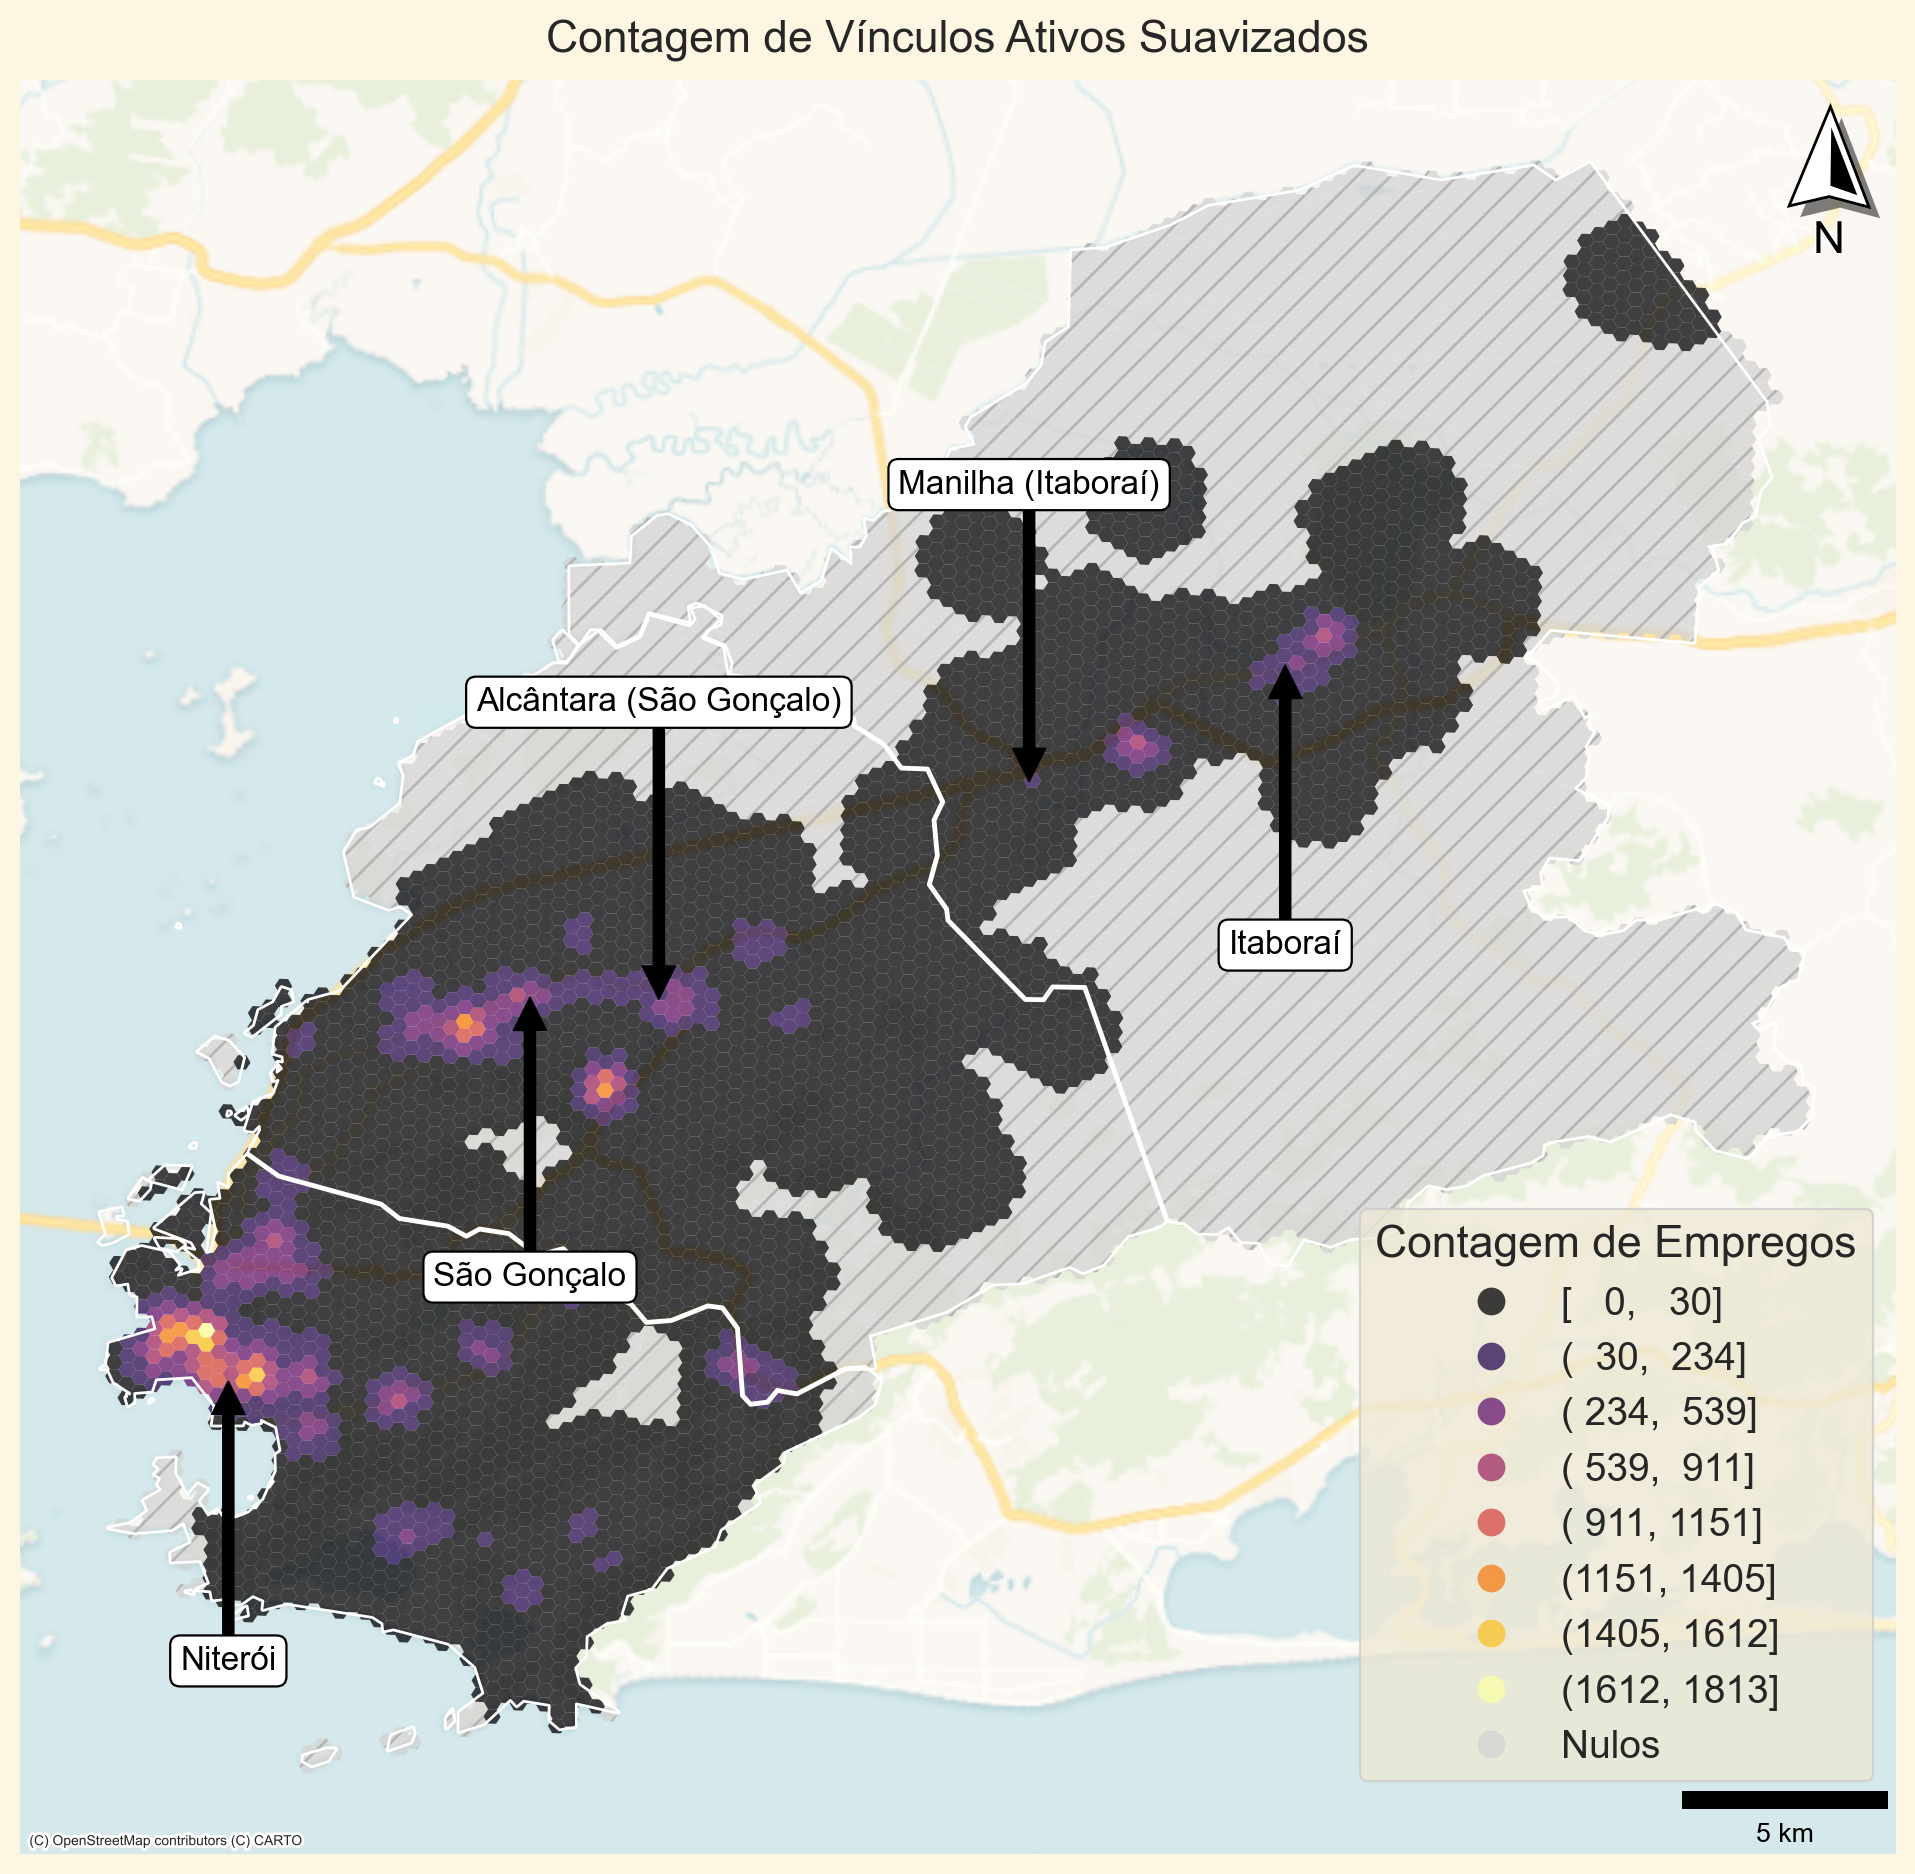

In [318]:
outpath = pathlib.Path(
    f"../outputs/mapas/rais{2023}_todos.png"
    )

plot_georretail_h3_map(
    foo.round(),
    value_col="vinculos_suavizados",
    title="Contagem de Vínculos Ativos Suavizados",
    cmap="inferno",
    scheme="HeadTailbreaks",  # 'Quantiles' é robusto
    k=4,  # Menos classes para o exemplo
    basemap_provider=ctx.providers.CartoDB.VoyagerNoLabels,  # Mapa base
    output_path=outpath,
    legend_title="Contagem de Empregos",
)

# Exercício

**Objetivo:** Compreender os fundamentos da análise de padrões de pontos (*Point Pattern Analysis*) e explorar técnicas para visualizar e interpretar eventos espaciais representados como pontos georreferenciados.

Abaixo, está um mapa com uma amostra ds emprgos da RAIS, representados por pontos que são a localização geogr;afica dos respectivos CEPs. 

Pontos no espaço podem representar fenômenos distintos dependendo de como os interpretamos. No caso da RAIS, ao geolocalizarmos estabelecimentos com base em seus CEPs, podemos tratá-los como **eventos que poderiam ocorrer em qualquer lugar da cidade, mas que se concentram em alguns pontos específicos**. Nesse contexto, nos interessa entender *por que* esses eventos (estabelecimentos) ocorrem em certas áreas e *como* estão distribuídos espacialmente.

Esse tipo de análise — conhecida como **padrão de pontos** — busca descrever e modelar a distribuição dos eventos no espaço. A distribuição pode ser:
- **Aleatória**, sem nenhuma estrutura evidente;
- **Agrupada**, sugerindo concentração em certas regiões;
- Ou **dispersa**, indicando distanciamento entre eventos.

A análise nos permite transformar listas de coordenadas em **fenômenos espaciais interpretáveis**, ajudando a responder perguntas como:
- Onde estão os centros de atividade econômica?
- Existem “vazios” no espaço urbano sem estabelecimentos?
- Há evidência de *clusters* (aglomerados) por setor ou tipo de empresa?

Trabalhe com os dados geolocalizados da RAIS, tratando cada ponto como uma observação de um processo espacial subjacente. A proposta é aplicar conceitos e ferramentas de análise de padrões pontuais para caracterizar a estrutura espacial dos dados — usando bibliotecas como `geopandas`, `pointpats` e `PySAL`.

Acompanhe o capítulo Point Pattern Analysis do livro [Geographic Data Science with Python](https://geographicdata.science/book/notebooks/08_point_pattern_analysis.html) e reproduza o exercício prático lá contido com os municípios acima. Documente o passo a passo e discuta e analise seus achados.

→ Note que exportamos dados de três anos (2021, 2022 e 2023). Extraia 2023 e faça as análises com esse subconjunto.
→ Você pode trabalhar com os dados agregados, mas pode ser interessante ver como a análise muda para as diferentes categorias do CONCLA.